In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [26]:
df = pd.read_parquet("results/vep/example_annotated.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet")
df

,chromosome,pos,ID,ref,alt,QUAL,FILTER,INFO,model_llr
0,Chr5,3500000,.,A,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-1.171289
1,Chr5,3500000,.,A,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-0.214262
2,Chr5,3500000,.,A,T,.,.,CSQ=T|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-0.242087
3,Chr5,3500001,.,C,A,.,.,CSQ=A|upstream_gene_variant|MODIFIER|ALF4|AT5G...,0.965767
4,Chr5,3500001,.,C,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|ALF4|AT5G...,0.651589
...,...,...,...,...,...,...,...,...,...
299995,Chr5,3599998,.,T,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|HY5|AT5G1...,0.086468
299996,Chr5,3599998,.,T,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|HY5|AT5G1...,0.435724
299997,Chr5,3599999,.,T,A,.,.,CSQ=A|upstream_gene_variant|MODIFIER|HY5|AT5G1...,-0.022641
299998,Chr5,3599999,.,T,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|HY5|AT5G1...,-0.543526


In [27]:
df["consequence"] = df.INFO.str.replace("CSQ=", "").str.split(",").apply(lambda x: ",".join(sorted(list(set([y.split("|")[1] for y in x])))))
df.consequence.value_counts()[:20]

downstream_gene_variant,upstream_gene_variant                                    80838
downstream_gene_variant,missense_variant,upstream_gene_variant                   27315
downstream_gene_variant,missense_variant                                         24706
downstream_gene_variant,intron_variant,upstream_gene_variant                     21435
downstream_gene_variant,intron_variant                                           16833
upstream_gene_variant                                                            15186
downstream_gene_variant                                                          14106
5_prime_UTR_variant,downstream_gene_variant,upstream_gene_variant                 8481
downstream_gene_variant,synonymous_variant,upstream_gene_variant                  8270
3_prime_UTR_variant,downstream_gene_variant                                       7662
downstream_gene_variant,synonymous_variant                                        7286
missense_variant,upstream_gene_variant     

In [28]:
df.consequence = df.consequence.str.replace("downstream_gene_variant,", "").astype(str)
df.consequence = df.consequence.str.replace(",downstream_gene_variant", "").astype(str)
df.consequence = df.consequence.str.replace("upstream_gene_variant,", "").astype(str)
df.consequence = df.consequence.str.replace(",upstream_gene_variant", "").astype(str)
df.consequence.value_counts()[:20]

upstream_gene_variant                                                       96024
missense_variant                                                            59807
intron_variant                                                              42270
3_prime_UTR_variant                                                         18315
synonymous_variant                                                          18078
downstream_gene_variant                                                     14106
5_prime_UTR_variant                                                         12537
non_coding_transcript_exon_variant                                           6417
intron_variant,missense_variant                                              4309
stop_gained                                                                  3637
5_prime_UTR_variant,intron_variant                                           2670
intron_variant&non_coding_transcript_variant                                 2583
splice_polypyrim

In [29]:
df.consequence.value_counts()

upstream_gene_variant                                                                   96024
missense_variant                                                                        59807
intron_variant                                                                          42270
3_prime_UTR_variant                                                                     18315
synonymous_variant                                                                      18078
                                                                                        ...  
missense_variant&splice_region_variant,stop_gained                                          1
intron_variant,stop_gained,stop_gained&splice_region_variant                                1
intron_variant,splice_donor_variant,synonymous_variant                                      1
3_prime_UTR_variant,stop_gained,stop_lost                                                   1
splice_polypyrimidine_tract_variant&splice_region_variant&in

In [30]:
df[~df.consequence.str.contains(",")].consequence.value_counts()

upstream_gene_variant                                                                                     96024
missense_variant                                                                                          59807
intron_variant                                                                                            42270
3_prime_UTR_variant                                                                                       18315
synonymous_variant                                                                                        18078
downstream_gene_variant                                                                                   14106
5_prime_UTR_variant                                                                                       12537
non_coding_transcript_exon_variant                                                                         6417
stop_gained                                                                                             

In [31]:
df[df.consequence.str.contains("start")].consequence.value_counts()

start_lost                                                           180
missense_variant,start_lost                                           36
intron_variant,start_lost                                             18
5_prime_UTR_variant,missense_variant,start_lost                       17
5_prime_UTR_variant,start_lost                                         9
5_prime_UTR_variant,non_coding_transcript_exon_variant,start_lost      9
5_prime_UTR_variant,start_lost,synonymous_variant                      1
Name: consequence, dtype: int64

In [32]:
df[df.consequence.str.contains("inter")].consequence.value_counts()

Series([], Name: consequence, dtype: int64)

In [33]:
df.consequence.replace("non_coding_transcript_exon_variant", "nc_transcript_exon_variant", inplace=True)

In [34]:
consequences_to_plot = [
    "start_lost",
    "missense_variant",
    "synonymous_variant",
    "stop_gained",
    #"stop_lost",
    "intron_variant",
    "upstream_gene_variant",
    "downstream_gene_variant",
    "splice_acceptor_variant",
    "splice_donor_variant",
    "3_prime_UTR_variant",
    "5_prime_UTR_variant",
    "nc_transcript_exon_variant",
    #"splice_polypyrimidine_tract_variant&intron_variant",
    #"splice_region_variant&intron_variant",
]

In [35]:
consequences_to_plot = df.groupby("consequence").model_llr.mean()[consequences_to_plot].sort_values().index.values

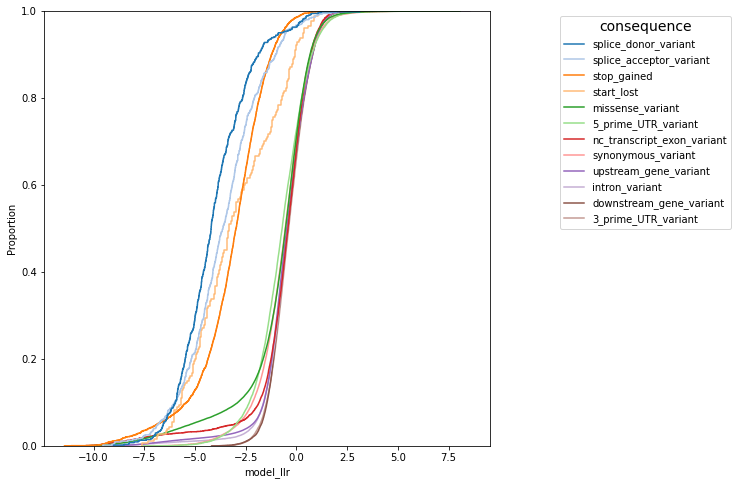

In [36]:
plt.figure(figsize=(8, 8))
g = sns.ecdfplot(
    data=df[df.consequence.isin(consequences_to_plot)],
    hue="consequence",
    hue_order=consequences_to_plot,
    x="model_llr",
    palette="tab20"
)
sns.move_legend(g, "upper right", bbox_to_anchor=(1.55, 1), ncol=1, title_fontsize=14)

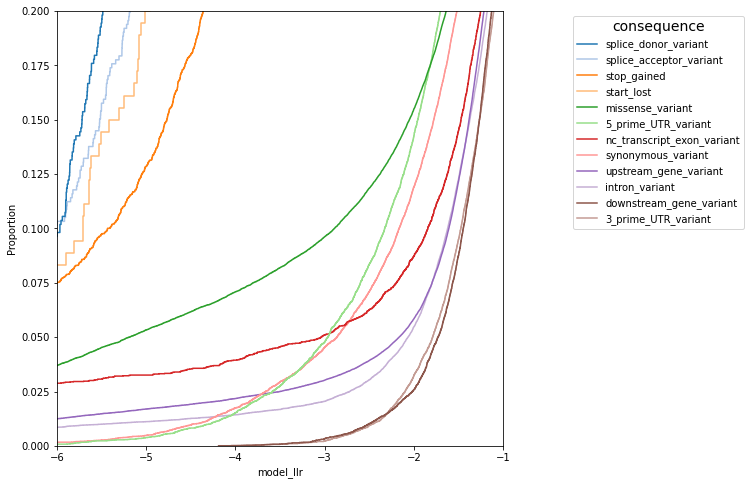

In [37]:
plt.figure(figsize=(8, 8))
g = sns.ecdfplot(
    data=df[df.consequence.isin(consequences_to_plot)],
    hue="consequence",
    hue_order=consequences_to_plot,
    x="model_llr",
    palette="tab20"
)
plt.xlim([-6, -1])
plt.ylim([0, 0.2])
sns.move_legend(g, "upper right", bbox_to_anchor=(1.55, 1), ncol=1, title_fontsize=14)

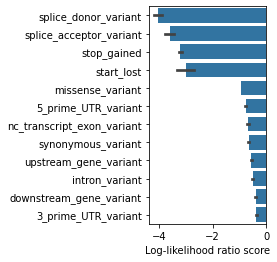

In [42]:
plt.figure(figsize=(2.1,4))
sns.barplot(
    data=df[df.consequence.isin(consequences_to_plot)],
    y="consequence",
    x="model_llr",
    color="C0",
    order=consequences_to_plot,
    #palette="tab20"
);
plt.xlabel("Log-likelihood ratio score")
plt.ylabel("")
plt.savefig("scores_by_consequence.svg", bbox_inches="tight")

,chromosome,pos,ID,ref,alt,QUAL,FILTER,INFO,model_llr,consequence
0,Chr5,3500000,.,A,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-1.171289,missense_variant
1,Chr5,3500000,.,A,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-0.214262,missense_variant
2,Chr5,3500000,.,A,T,.,.,CSQ=T|upstream_gene_variant|MODIFIER|ALF4|AT5G...,-0.242087,missense_variant
3,Chr5,3500001,.,C,A,.,.,CSQ=A|upstream_gene_variant|MODIFIER|ALF4|AT5G...,0.965767,missense_variant
4,Chr5,3500001,.,C,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|ALF4|AT5G...,0.651589,missense_variant
...,...,...,...,...,...,...,...,...,...,...
299995,Chr5,3599998,.,T,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|HY5|AT5G1...,0.086468,synonymous_variant
299996,Chr5,3599998,.,T,G,.,.,CSQ=G|upstream_gene_variant|MODIFIER|HY5|AT5G1...,0.435724,synonymous_variant
299997,Chr5,3599999,.,T,A,.,.,CSQ=A|upstream_gene_variant|MODIFIER|HY5|AT5G1...,-0.022641,missense_variant
299998,Chr5,3599999,.,T,C,.,.,CSQ=C|upstream_gene_variant|MODIFIER|HY5|AT5G1...,-0.543526,missense_variant


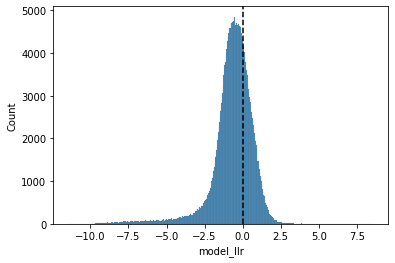

In [16]:
sns.histplot(
    data=df,
    x="model_llr"
)
plt.axvline(0, linestyle="--", color="black")